In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pathlib
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import igraph as ig
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from modutils import mod_calc
device = torch.device('cpu')

In [2]:
file_path = "../datasets/starwars-full-interactions-allCharacters-merged.json"

with open(file_path) as json_file:
    data = json.load(json_file)
    
metadata = data['nodes']
edges = data['links']

df_metadata = pd.DataFrame(metadata)
df_edges = pd.DataFrame(edges)

df_metadata.reset_index(inplace = True)

df_metadata.rename(columns = {'index' : 'node_id'}, inplace = True)

nodes_list = list(df_metadata.node_id)

edges_list = list(zip(df_edges.source, df_edges.target))

weight = list(df_edges.value)

# initialize a new graph object
G = nx.Graph()

# populate the graph with nodes
G.add_nodes_from(nodes_list)

# populate the graph with edges
G.add_edges_from(edges_list, edge_attr =df_edges.value)

In [3]:
# G = nx.read_gml("datasets/lesmis.gml", label = 'id')
print(nx.info(G))
comm_dict = partition(G)
clusters_number = len(np.array(list(set(comm_dict.values())))) #set the number of clusters required here

Name: 
Type: Graph
Number of nodes: 111
Number of edges: 444
Average degree:   8.0000


In [4]:
A_hat = nx.adjacency_matrix(G).todense()
X = np.identity(G.number_of_nodes(), dtype=np.float)  

In [5]:
class CDCGS(nn.Module):
    def __init__(self, A_hat, num_feat, num_hidden):
        super(CDCGS, self).__init__()
        self.num_feat = num_feat
        self.num_hidden = num_hidden
        self.A_hat = A_hat
        self.W_0 = nn.Parameter(torch.ones(num_feat, num_hidden))
        I = F.one_hot(torch.tensor(random.sample(range(0, num_feat), num_feat)), num_classes=num_feat)
        self.I = torch.tensor(I,dtype=torch.float)

    def forward(self, X, A_hat,temp):
        global featureSelector
        global weight_feature
        featureSelector = self.W_0
        results = torch.zeros(self.W_0.size())
        x = 500
        for i in range(x):
            results += F.gumbel_softmax(self.W_0,tau=temp,hard=False)
        weight_feature = results/x

        H = torch.mm(torch.mm(self.I,A_hat),self.I.T)
        H = torch.mm(torch.mm(weight_feature.T,A_hat),weight_feature)
        H = torch.div(H, H.sum(axis=0))
        m = nn.Softmax(dim=0)
        return m(H)

num_feat = len(G.nodes())
num_hidden = clusters_number

model = CDCGS(A_hat, num_feat, num_hidden).to(device)


def lossFn(output,exp): 
    return torch.sum((torch.diag(-torch.log(output))))

optimizer = optim.Adam(model.parameters(),lr=1e-2,weight_decay=0,betas=(0.5, 0.999), eps=1e-08)


A_hat_tensor = torch.Tensor(A_hat).to(device)
X_tensor = torch.Tensor(X).to(device)

loss_hist = []
acc_hist = []
temp = 3

for epoch in range(600):
    model.train()
    model.zero_grad()
    if(epoch == 75):
        temp = 2.5
    elif(epoch == 100):
        temp = 2
    elif(epoch == 150):
        temp = 1.5
    elif(epoch == 200):
        temp = 1
    elif(epoch == 300):
        temp = 0.5
    elif(epoch == 400):
        temp = 0.1
    output = model(X_tensor, A_hat_tensor,temp)
    loss = lossFn(output,torch.diag(torch.ones(output.size()[0])))
    loss_hist.append(loss.item())
    print('loss',epoch,loss)
    loss.backward()
    optimizer.step()


<ipython-input-5-cb27054fd8d8>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.I = torch.tensor(I,dtype=torch.float)


loss 0 tensor(8.0472, grad_fn=<SumBackward0>)
loss 1 tensor(8.0472, grad_fn=<SumBackward0>)
loss 2 tensor(8.0472, grad_fn=<SumBackward0>)
loss 3 tensor(8.0472, grad_fn=<SumBackward0>)
loss 4 tensor(8.0472, grad_fn=<SumBackward0>)
loss 5 tensor(8.0471, grad_fn=<SumBackward0>)
loss 6 tensor(8.0471, grad_fn=<SumBackward0>)
loss 7 tensor(8.0470, grad_fn=<SumBackward0>)
loss 8 tensor(8.0470, grad_fn=<SumBackward0>)
loss 9 tensor(8.0469, grad_fn=<SumBackward0>)
loss 10 tensor(8.0468, grad_fn=<SumBackward0>)
loss 11 tensor(8.0466, grad_fn=<SumBackward0>)
loss 12 tensor(8.0464, grad_fn=<SumBackward0>)
loss 13 tensor(8.0461, grad_fn=<SumBackward0>)
loss 14 tensor(8.0460, grad_fn=<SumBackward0>)
loss 15 tensor(8.0457, grad_fn=<SumBackward0>)
loss 16 tensor(8.0452, grad_fn=<SumBackward0>)
loss 17 tensor(8.0447, grad_fn=<SumBackward0>)
loss 18 tensor(8.0441, grad_fn=<SumBackward0>)
loss 19 tensor(8.0438, grad_fn=<SumBackward0>)
loss 20 tensor(8.0432, grad_fn=<SumBackward0>)
loss 21 tensor(8.0427, 

loss 173 tensor(7.2894, grad_fn=<SumBackward0>)
loss 174 tensor(7.2830, grad_fn=<SumBackward0>)
loss 175 tensor(7.2797, grad_fn=<SumBackward0>)
loss 176 tensor(7.2678, grad_fn=<SumBackward0>)
loss 177 tensor(7.2642, grad_fn=<SumBackward0>)
loss 178 tensor(7.2541, grad_fn=<SumBackward0>)
loss 179 tensor(7.2506, grad_fn=<SumBackward0>)
loss 180 tensor(7.2424, grad_fn=<SumBackward0>)
loss 181 tensor(7.2378, grad_fn=<SumBackward0>)
loss 182 tensor(7.2289, grad_fn=<SumBackward0>)
loss 183 tensor(7.2257, grad_fn=<SumBackward0>)
loss 184 tensor(7.2161, grad_fn=<SumBackward0>)
loss 185 tensor(7.2053, grad_fn=<SumBackward0>)
loss 186 tensor(7.1995, grad_fn=<SumBackward0>)
loss 187 tensor(7.1926, grad_fn=<SumBackward0>)
loss 188 tensor(7.1885, grad_fn=<SumBackward0>)
loss 189 tensor(7.1798, grad_fn=<SumBackward0>)
loss 190 tensor(7.1690, grad_fn=<SumBackward0>)
loss 191 tensor(7.1652, grad_fn=<SumBackward0>)
loss 192 tensor(7.1594, grad_fn=<SumBackward0>)
loss 193 tensor(7.1524, grad_fn=<SumBack

loss 344 tensor(6.1038, grad_fn=<SumBackward0>)
loss 345 tensor(6.1028, grad_fn=<SumBackward0>)
loss 346 tensor(6.1013, grad_fn=<SumBackward0>)
loss 347 tensor(6.1012, grad_fn=<SumBackward0>)
loss 348 tensor(6.1009, grad_fn=<SumBackward0>)
loss 349 tensor(6.0997, grad_fn=<SumBackward0>)
loss 350 tensor(6.1003, grad_fn=<SumBackward0>)
loss 351 tensor(6.1035, grad_fn=<SumBackward0>)
loss 352 tensor(6.1027, grad_fn=<SumBackward0>)
loss 353 tensor(6.0982, grad_fn=<SumBackward0>)
loss 354 tensor(6.0975, grad_fn=<SumBackward0>)
loss 355 tensor(6.1003, grad_fn=<SumBackward0>)
loss 356 tensor(6.0988, grad_fn=<SumBackward0>)
loss 357 tensor(6.0975, grad_fn=<SumBackward0>)
loss 358 tensor(6.0966, grad_fn=<SumBackward0>)
loss 359 tensor(6.0995, grad_fn=<SumBackward0>)
loss 360 tensor(6.0984, grad_fn=<SumBackward0>)
loss 361 tensor(6.0968, grad_fn=<SumBackward0>)
loss 362 tensor(6.0969, grad_fn=<SumBackward0>)
loss 363 tensor(6.0972, grad_fn=<SumBackward0>)
loss 364 tensor(6.0970, grad_fn=<SumBack

loss 516 tensor(6.0513, grad_fn=<SumBackward0>)
loss 517 tensor(6.0532, grad_fn=<SumBackward0>)
loss 518 tensor(6.0532, grad_fn=<SumBackward0>)
loss 519 tensor(6.0529, grad_fn=<SumBackward0>)
loss 520 tensor(6.0527, grad_fn=<SumBackward0>)
loss 521 tensor(6.0548, grad_fn=<SumBackward0>)
loss 522 tensor(6.0520, grad_fn=<SumBackward0>)
loss 523 tensor(6.0530, grad_fn=<SumBackward0>)
loss 524 tensor(6.0512, grad_fn=<SumBackward0>)
loss 525 tensor(6.0517, grad_fn=<SumBackward0>)
loss 526 tensor(6.0535, grad_fn=<SumBackward0>)
loss 527 tensor(6.0525, grad_fn=<SumBackward0>)
loss 528 tensor(6.0530, grad_fn=<SumBackward0>)
loss 529 tensor(6.0503, grad_fn=<SumBackward0>)
loss 530 tensor(6.0495, grad_fn=<SumBackward0>)
loss 531 tensor(6.0523, grad_fn=<SumBackward0>)
loss 532 tensor(6.0520, grad_fn=<SumBackward0>)
loss 533 tensor(6.0529, grad_fn=<SumBackward0>)
loss 534 tensor(6.0511, grad_fn=<SumBackward0>)
loss 535 tensor(6.0536, grad_fn=<SumBackward0>)
loss 536 tensor(6.0522, grad_fn=<SumBack

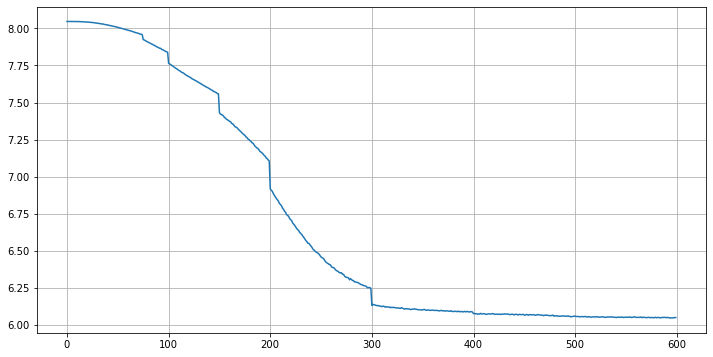

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(loss_hist)
plt.grid(True)
plt.show()

In [7]:
gumbel_matrix = weight_feature.detach().max(dim=1)[1]
labels_pred = gumbel_matrix.data.numpy()

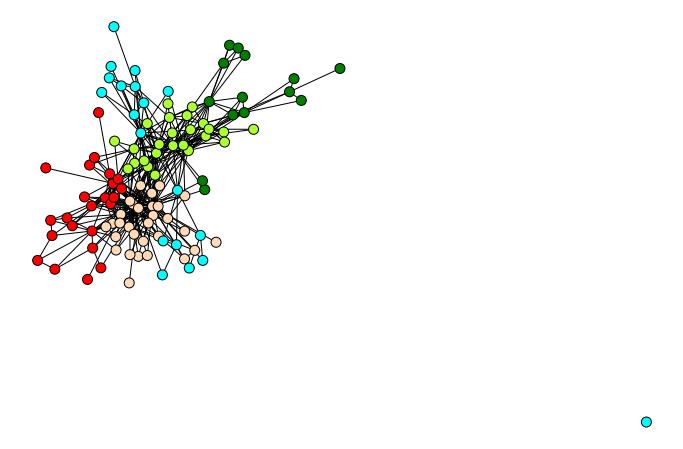

In [8]:
# plot decoration
plt.figure(figsize=(12, 8)) 

pos = nx.spring_layout(G)

color = []
for c in range(len(gumbel_matrix)):
    if(gumbel_matrix[c] == 0):
        color.append('r')
    elif(gumbel_matrix[c] == 1):
        color.append('g')
    elif(gumbel_matrix[c] == 2):
        color.append('peachpuff')
    elif(gumbel_matrix[c] == 3):
        color.append('greenyellow')
    elif(gumbel_matrix[c] == 4):
        color.append('aqua')
    elif(gumbel_matrix[c] == 5):
        color.append('lightcyan')
    elif(gumbel_matrix[c] == 6):
        color.append('thistle')
    elif(gumbel_matrix[c] == 7):
        color.append('gold')
    elif(gumbel_matrix[c] == 8):
        color.append('m')
        
nx.draw_networkx(G, pos=pos, node_size=100, node_color=color, edgecolors = "black",with_labels=False)

plt.axis('off')
pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/gumbel_softmax.png")
plt.show()


In [9]:
print("Number of communities: ", len(pd.Series(gumbel_matrix).unique()))

Number of communities:  5
